<a href="https://colab.research.google.com/github/GiulioCMSanto/HDSIdent/blob/master/notebooks/SISO%20Systems/Potential%20Intervals/siso_exponentially_weighted_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SISO Potential Intervals: Exponentially Weighted Moving Average (EWMA)

[HDSIdent: Historical Data Segmentation for System Identification](https://github.com/GiulioCMSanto/HDSIdent)

This notebook explores how to obtain potential intervals for system identification through a Exponentially Weighted Moving Average (EWMA) filter, considering Single-Input Single-Output systems.

**How to reference this work?**

[SANTO, G. C. M. Data Mining Techniques Applied to Historical Data of Industrial Processes 
as a Tool to Find Time Intervals Suitable for System Identification. Masters dissertation 
– Polytechnic School of the University of São Paulo, São Paulo, Brasil, 2020. 
DOI: 10.13140/RG.2.2.13295.46240](https://www.researchgate.net/publication/347511108_Data_Mining_Techniques_Applied_to_Historical_Data_of_Industrial_Processes_as_a_Tool_to_Find_Time_Intervals_Suitable_for_System_Identification?channel=doi&linkId=5fdf5293a6fdccdcb8e856c4&showFulltext=true)






**About the Method**

The method here presented was proposed in the following works:

```
PERETZKI, D. et al. Data mining of historic data for process identification.
In: Proceedings of the 2011 AIChE Annual Meeting, p. 1027–1033, 2011.

BITTENCOURT, A. C. et al. An algorithm for finding process identification
intervals from normal operating data. Processes, v. 3, p. 357–383, 2015.
```

The implementation here presented, however, is also based on the following related works:

```
PATEL, A. Data Mining of Process Data in Mutlivariable Systems.
Degree project in electrical engineering — Royal Institute of Technology,
Stockholm, Sweden, 2016.

ARENGAS, D.; KROLL, A. A Search Method for Selecting Informative Data in Predominantly
Stationary Historical Records for Multivariable System Identification.
In: Proceedings of the 21st International Conference on System Theory,
Control and Computing (ICSTCC). Sinaia, Romenia: IEEE, 2017a. p. 100–105.

ARENGAS, D.; KROLL, A. Searching for informative intervals in predominantly stationary
data records to support system identification. In: Proceedings of the XXVI International
Conference on Information, Communication and Automation Technologies (ICAT). Sarajevo,
Bosnia-Herzegovina: IEEE, 2017b.

WANG, J. et al. Searching historical data segments for process identification
in feedback control loops. Computers and Chemical Engineering, v. 112, n. 6, p. 6–16, 2018.
```

**About the [Dataset](https://github.com/GiulioCMSanto/HDSIdent/tree/master/data/water_tank)**

The dataset here adopted was produced through simulation in the dissertation (SANTO, G. C. M., 2020). The dataset is created based on the work in (WANG et al., 2018). The transfer functions adopted in the simulation were directly extracted from (WANG et al., 2018 apud YU et al., 2011), as well as the simulation idea, where similar signals were produced.

**References**:

```
SANTO, G. C. M. Data Mining Techniques Applied to Historical Data of Industrial Processes 
as a Tool to Find Time Intervals Suitable for System Identification. Masters dissertation 
– Polytechnic School of the University of São Paulo, São Paulo, Brasil, 2020. 
DOI: 10.13140/RG.2.2.13295.46240

WANG, J. et al. Searching historical data segments for process identification
in feedback control loops. Computers and Chemical Engineering, v. 112, n. 6, p. 6–16, 2018.

YU, Z. et al. Performance assessment of pid control loops subject to setpoint
changes. Journal of Process Control, v. 21, n. 8, p. 1164–1171, 2011.
````

In [6]:
!git clone https://github.com/GiulioCMSanto/HDSIdent.git

Cloning into 'HDSIdent'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 820 (delta 43), reused 37 (delta 15), pack-reused 715
Receiving objects: 100% (820/820), 10.67 MiB | 24.67 MiB/s, done.
Resolving deltas: 100% (380/380), done.


In [7]:
# Change into the directory for install
%cd HDSIdent/

/content/HDSIdent


In [8]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating HDSIdent.egg-info
writing HDSIdent.egg-info/PKG-INFO
writing dependency_links to HDSIdent.egg-info/dependency_links.txt
writing requirements to HDSIdent.egg-info/requires.txt
writing top-level names to HDSIdent.egg-info/top_level.txt
writing manifest file 'HDSIdent.egg-info/SOURCES.txt'
writing manifest file 'HDSIdent.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/HDSIdent
copying HDSIdent/__init__.py -> build/lib/HDSIdent
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/HDSIdent
copying build/lib/HDSIdent/__init__.py -> build/bdist.linux-x86_64/egg/HDSIdent
byte-compiling build/bdist.linux-x86_64/egg/HDSIdent/__init__.py to __init__.cpython-36.pyc
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying HDSIdent.egg-info/PKG-INFO -> build/bdist.linu

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

import plotly
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode

plotly.io.renderers.default = 'colab'

%matplotlib inline
sns.set_style('darkgrid')

In [10]:
from HDSIdent.data_treatment.data_preprocessing import Preprocessing
from HDSIdent.initial_intervals.exponentially_weighted import ExponentiallyWeighted

## **1. Read Data**

In [11]:
mv_url = 'https://raw.githubusercontent.com/GiulioCMSanto/HDSIdent/master/data/water_tank/siso_simu_mv.csv'
sp_url = 'https://raw.githubusercontent.com/GiulioCMSanto/HDSIdent/master/data/water_tank/siso_simu_sp.csv'
y_url = 'https://raw.githubusercontent.com/GiulioCMSanto/HDSIdent/master/data/water_tank/siso_simu_y.csv'

In [12]:
mv = pd.read_csv(mv_url, error_bad_lines=False, header=None)
sp = pd.read_csv(sp_url, error_bad_lines=False, header=None)
y = pd.read_csv(y_url, error_bad_lines=False, header=None)

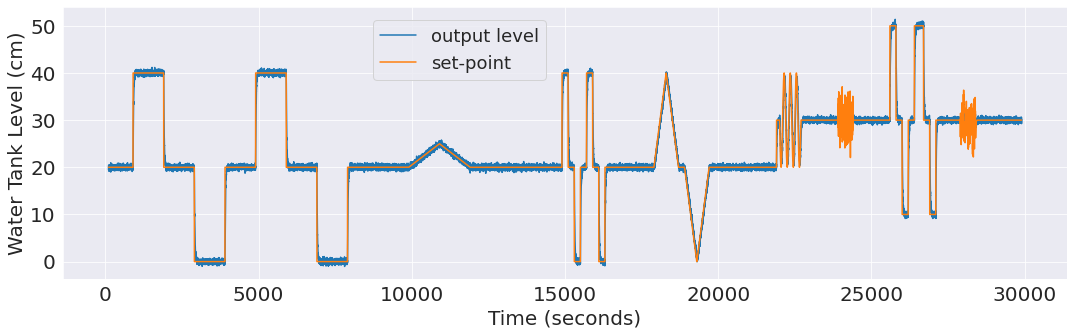

In [13]:
plt.figure(figsize=(18,5));
plt.plot(y[100:],label="output level");
plt.plot(sp[100:],label="set-point");
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
plt.ylabel("Water Tank Level (cm)", fontsize=20);
plt.xlabel("Time (seconds)", fontsize=20);
plt.legend(fontsize=18,bbox_to_anchor=(0.3,0.7));

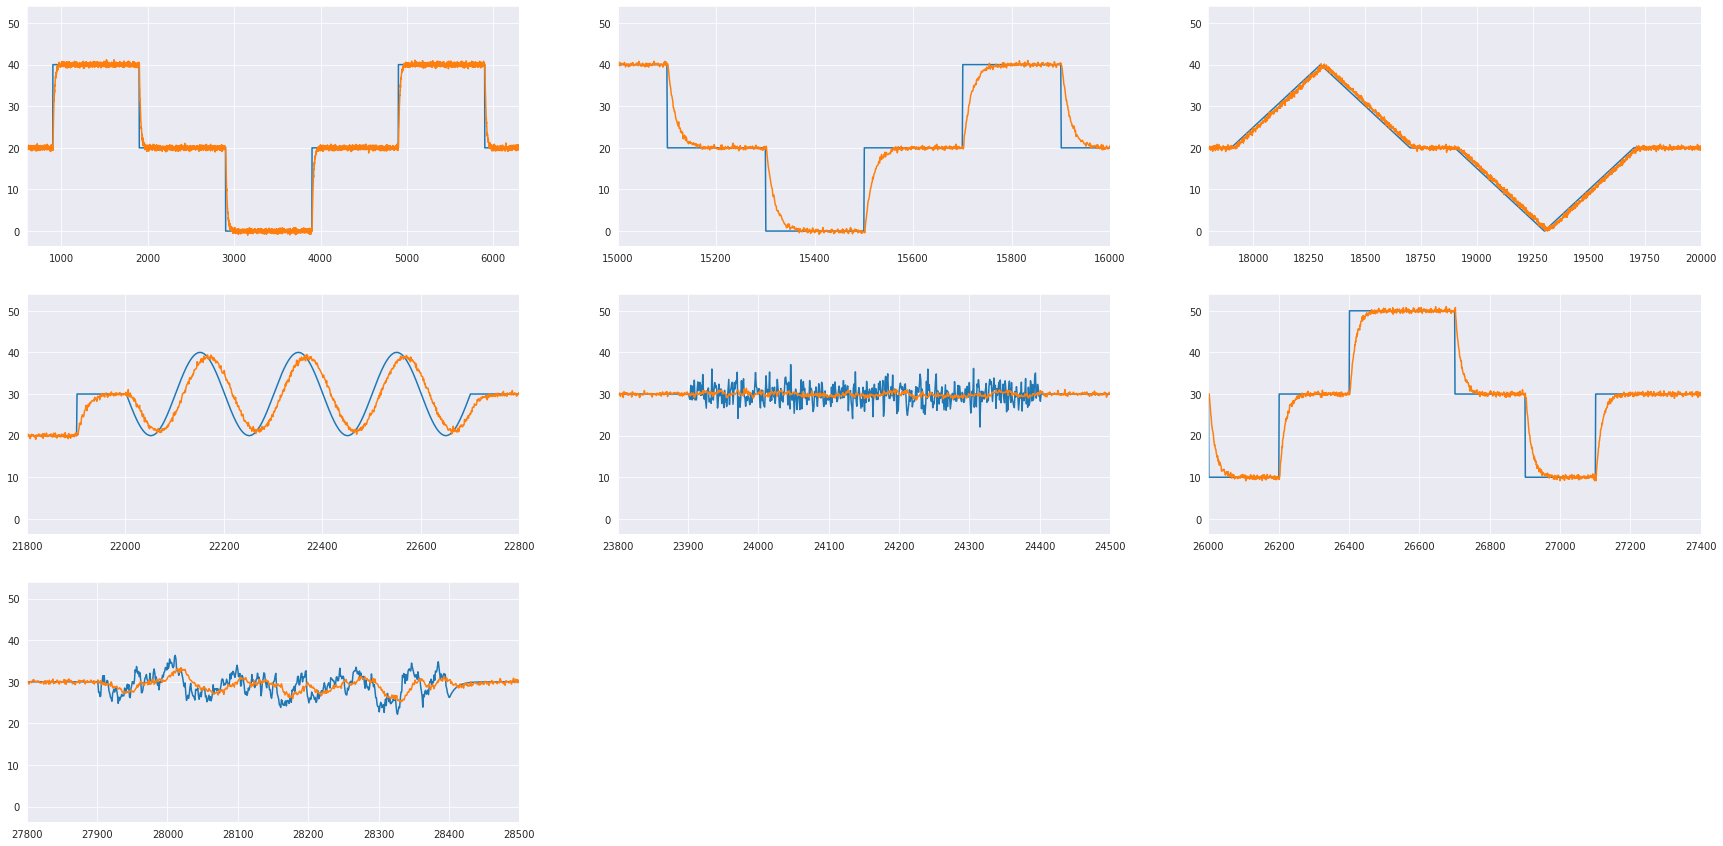

In [ ]:
plt.figure(figsize=(30,15))

plt.subplot(3,3,1)
plt.plot(sp);
plt.plot(y);
plt.xlim(600,6300);

plt.subplot(3,3,2)
plt.plot(sp);
plt.plot(y);
plt.xlim(15000,16000);

plt.subplot(3,3,3)
plt.plot(sp);
plt.plot(y);
plt.xlim(17800,20000);

plt.subplot(3,3,4)
plt.plot(sp);
plt.plot(y);
plt.xlim(21800,22800);

plt.subplot(3,3,5)
plt.plot(sp);
plt.plot(y);
plt.xlim(23800,24500);

plt.subplot(3,3,6)
plt.plot(sp);
plt.plot(y);
plt.xlim(26000,27400);

plt.subplot(3,3,7)
plt.plot(sp);
plt.plot(y);
plt.xlim(27800,28500);

## **2. Data Pre-processing**

In [18]:
pp = Preprocessing(
        scaler='MinMaxScaler',
        feature_range=(-0.5,0.5),
        k=100);

In [19]:
X_clean, Y_clean = pp.fit_transform(X=np.concatenate([mv,sp],axis=1),
                                    y=y)

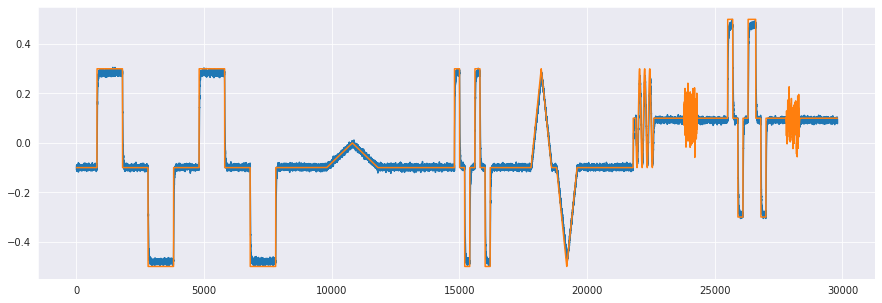

In [20]:
plt.figure(figsize=(15,5))
plt.plot(Y_clean);
plt.plot(X_clean[:,1]);

## **3. Find Potential Intervals with the Set-point and the Output Variable**

In [21]:
df = pd.DataFrame()
df['SP'] = np.squeeze(X_clean[:,1])
df['Y'] = np.squeeze(Y_clean)

## **4. Verify the Effect of the Forgetting Factor**

In [ ]:
forget_fact_arr = np.array([0.0005, 0.002, 0.005])

count = 0
S_plot_arr = []
mu_plot_arr = []
for fact in forget_fact_arr:
    count+=1
    print("Iteration {}/{}".format(count,len(forget_fact_arr)))
    EW = ExponentiallyWeighted(
              forgetting_fact_v = np.array([fact]*2),
              forgetting_fact_u = np.array([fact]*2),
              n_jobs=-1
          )
    EW.fit(X=df[['SP']],y=df[['Y']])
    S_plot_arr.append(EW._v_k_arr)
    mu_plot_arr.append(EW._mu_k_arr)

Iteration 1/3
Iteration 2/3
Iteration 3/3


### **4.1 Variance Filter**

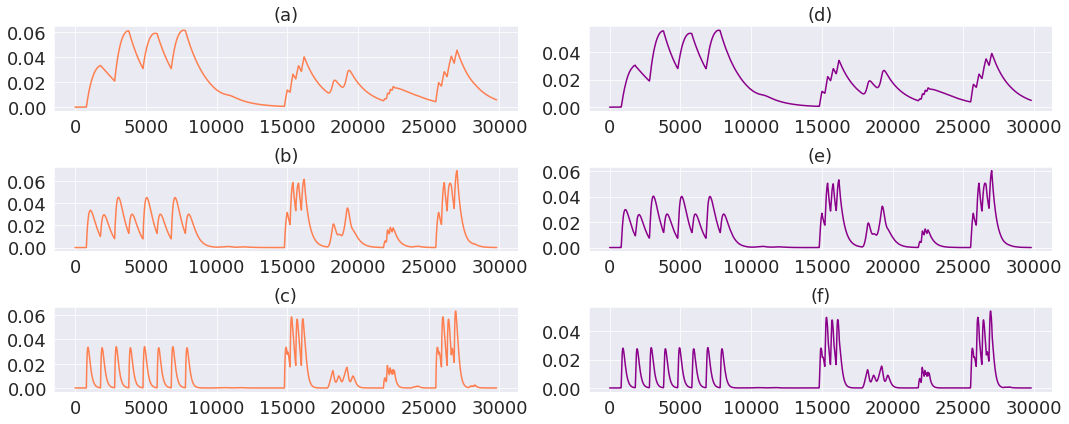

In [ ]:
plt.figure(figsize=(15,6))

plt.subplot(3,2,1);
plt.plot(S_plot_arr[0][:,0], color='coral');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(a)", fontsize=18);

plt.subplot(3,2,2);
plt.plot(S_plot_arr[0][:,1], color='darkmagenta');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(d)", fontsize=18);

plt.subplot(3,2,3);
plt.plot(S_plot_arr[1][:,0], color='coral');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(b)", fontsize=18);

plt.subplot(3,2,4);
plt.plot(S_plot_arr[1][:,1], color='darkmagenta');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(e)", fontsize=18);

plt.subplot(3,2,5);
plt.plot(S_plot_arr[2][:,0], color='coral');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(c)", fontsize=18);

plt.subplot(3,2,6);
plt.plot(S_plot_arr[2][:,1], color='darkmagenta');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(f)", fontsize=18);
plt.tight_layout();

### **4.2 Average Filter**

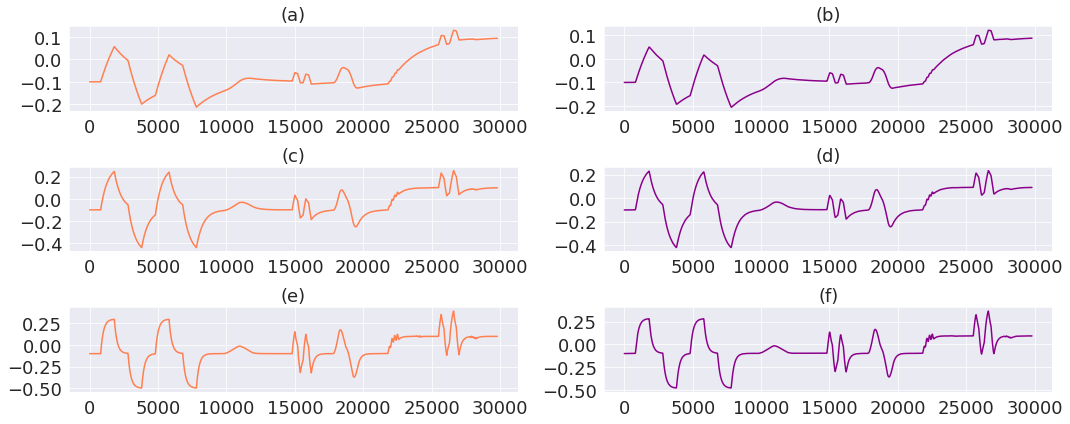

In [ ]:
plt.figure(figsize=(15,6))

plt.subplot(3,2,1);
plt.plot(mu_plot_arr[0][:,0], color='coral');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(a)", fontsize=18);

plt.subplot(3,2,2);
plt.plot(mu_plot_arr[0][:,1], color='darkmagenta');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(b)", fontsize=18);

plt.subplot(3,2,3);
plt.plot(mu_plot_arr[1][:,0], color='coral');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(c)", fontsize=18);

plt.subplot(3,2,4);
plt.plot(mu_plot_arr[1][:,1], color='darkmagenta');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(d)", fontsize=18);

plt.subplot(3,2,5);
plt.plot(mu_plot_arr[2][:,0], color='coral');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(e)", fontsize=18);

plt.subplot(3,2,6);
plt.plot(mu_plot_arr[2][:,1], color='darkmagenta');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(f)", fontsize=18);

plt.tight_layout();

## **5. Choosing Parameters**

In [ ]:
EW = ExponentiallyWeighted(
        forgetting_fact_v = np.array([0.005,0.005]),
        forgetting_fact_u = np.array([0.005,0.005]),
        H_v = [0.004,0.004],
        verbose=0,
        n_jobs=-1
        )

In [ ]:
start = time()
EW.fit(X=df[['SP']],y=df[['Y']]);
end = time()

In [ ]:

print("Execution time: {}".format(end-start))

Execution time: 12.361042261123657


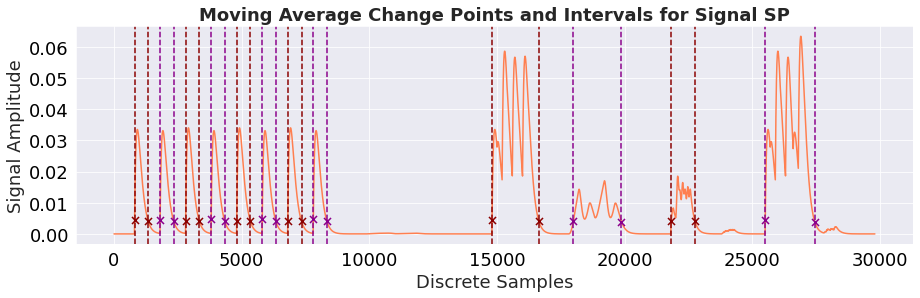

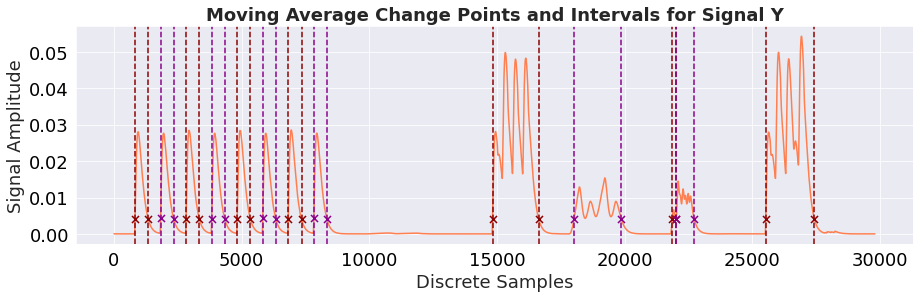

In [ ]:
EW.plot_change_points(X=df[['SP']],y=df[['Y']])

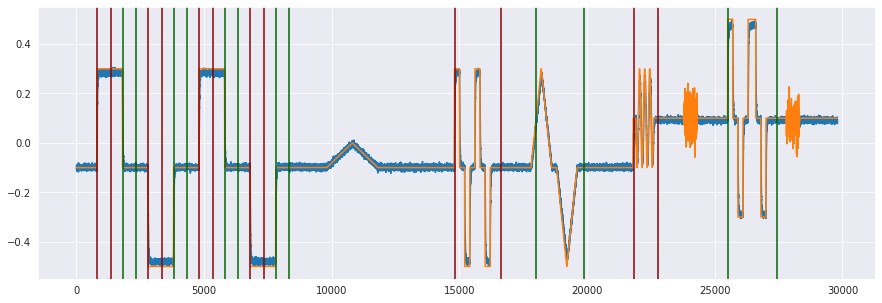

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(Y_clean);
plt.plot(X_clean[:,1]);

counter = 2;
for key, interval in EW.unified_intervals.items():
    if counter%2==0:
        color = 'darkred'
    else:
        color = 'darkgreen'
        
    plt.axvline(np.min(interval),color=color);
    plt.axvline(np.max(interval),color=color);
    
    counter+=1

## **6. Heatmap Analysis**

In [15]:
def create_grid_of_intervals(forgetting_factors_arr, variance_threshold_arr, multi_factor):
  """
  This function makes all possible combinations of forgetting factors and
  variance thresholds and, for each combination, computes the number of
  mined intervals and the average length of these intervals. This computation
  is made considering. the set-point and the output variable.

  Arguments:
    forgetting_factors_arr: an array of forgetting factors
    variance_threshold_arr: an array of thresholds for the variance filter
    multi_factor: the multiplication factor in the relationship between the 
    average and the variance forgetting factors: forgetting_fact_u = multi_factor*forgetting_fact_v
  
  Output:
    num_intervals_mtx: a matrix with the number of resulting intervals for each
    parameter combination
    len_intervals_mtx: a matrix with the average length of the resulting intervals
    for each parameter combination
  """

  factor_grid, H_v_grid = np.meshgrid(forgetting_factors_arr, variance_threshold_arr)
  num_intervals_mtx = np.zeros((factor_grid.shape[0],factor_grid.shape[1]))
  len_intervals_mtx = np.zeros((factor_grid.shape[0],factor_grid.shape[1]))

  counter = 0
  for idx_1 in range(factor_grid.shape[0]):
      for idx_2 in range(factor_grid.shape[1]):
          
          counter+=1
          
          if counter%20==0:
              print("Iteration {}/{}".format(counter,factor_grid.shape[0]*factor_grid.shape[1]))
      
          forgetting_fact_v = factor_grid[idx_1,idx_2]
          forgetting_fact_u = factor_grid[idx_1,idx_2]*multi_factor
          H_v = [H_v_grid[idx_1,idx_2]]*2

          EW = ExponentiallyWeighted(forgetting_fact_v = forgetting_fact_v,
                                  forgetting_fact_u = forgetting_fact_u,
                                  H_v = H_v,
                                  verbose=0,
                                  n_jobs=-1)     
          
          intervals = EW.fit(X=df[['SP']],y=df[['Y']]);

          num_intervals_mtx[idx_1,idx_2] = len(intervals.keys())

          len_arr = []
          for key, value in intervals.items():
              len_arr.append(len(value))
              
          len_intervals_mtx[idx_1,idx_2] = np.mean(len_arr)
          
  len_intervals_mtx = np.nan_to_num(len_intervals_mtx,0)

  return num_intervals_mtx, len_intervals_mtx

In [16]:
def plot_grid(forgetting_factors_arr, variance_threshold_arr, intervals_mtx, zmin, zmax, title):
  """
  This function plots a grid of interval metrics
  provided in the intervals_mtx variable.

  Arguments:
    forgetting_factors_arr: an array of forgetting factors
    variance_threshold_arr: an array of thresholds for the variance filter
    num_intervals_mtx: matrix of interval lengths
    zmin: axis minimum size
    zmax: axis maximum size
    title: plot title
  """
  fig = go.Figure(data =
      go.Contour(
          z=intervals_mtx,
          x=forgetting_factors_arr, # horizontal axis
          y=variance_threshold_arr, # vertical axis,
          zmin=zmin,
          zmax=zmax,
          colorscale='bugn',
                  contours=dict(
              showlabels = True, # show labels on contours
              labelfont = dict( # label font properties
                  size = 26,
                  color = 'black',
              )
      )))

  fig.update_layout(
      autosize=False,
      width=500,
      height=500,
      title={
            'text':title,
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
      xaxis_title=r"$\Large \text{Variance Forgetting Factor }(\lambda_{S})$",
      yaxis_title=r"$\Large \text{Variance Threshold } (l_{S})$",
      font=dict(
          family="Times New Roman",
          size=18,
          color="black"
      ),
  )

  fig.update_xaxes(range=[0, 0.015])
  fig.update_yaxes(range=[0.001, 0.11])
  fig.show()

### **6.1 forgetting_fact_u = forgetting_fact_v**

In [ ]:
factor_grid = [0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.1]
H_v_grid = [0.0001, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.08, 0.1]

num_intervals_mtx, len_intervals_mtx = create_grid_of_intervals(
                                          forgetting_factors_arr=factor_grid, 
                                          variance_threshold_arr=H_v_grid, 
                                          multi_factor=1)

Iteration 20/90
Iteration 40/90


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



Iteration 60/90
Iteration 80/90


In [ ]:
plot_grid(forgetting_factors_arr = factor_grid, 
          variance_threshold_arr = H_v_grid, 
          intervals_mtx = num_intervals_mtx, 
          zmin = 0, 
          zmax = 30, 
          title = "Number of Intervals VS EWMA Parameters")

In [ ]:
plot_grid(forgetting_factors_arr = factor_grid, 
          variance_threshold_arr = H_v_grid, 
          intervals_mtx = len_intervals_mtx, 
          zmin = 0, 
          zmax = 2000, 
          title = "Average Intervals Length VS EWMA Parameters")

### **6.2 forgetting_fact_u = 2 * forgetting_fact_v**

In [ ]:
factor_grid = [0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.1]
H_v_grid = [0.0001, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.08, 0.1]

num_intervals_mtx, len_intervals_mtx = create_grid_of_intervals(
                                          forgetting_factors_arr=factor_grid, 
                                          variance_threshold_arr=H_v_grid, 
                                          multi_factor=2)

Iteration 20/90


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



Iteration 40/90
Iteration 60/90
Iteration 80/90


In [ ]:
plot_grid(forgetting_factors_arr = factor_grid, 
          variance_threshold_arr = H_v_grid, 
          intervals_mtx = num_intervals_mtx, 
          zmin = 0, 
          zmax = 30, 
          title = "Number of Intervals VS EWMA Parameters")

In [ ]:
plot_grid(forgetting_factors_arr = factor_grid, 
          variance_threshold_arr = H_v_grid, 
          intervals_mtx = len_intervals_mtx, 
          zmin = 0, 
          zmax = 2000, 
          title = "Average Intervals Length VS EWMA Parameters")

### **6.3 forgetting_fact_u = 0.5 * forgetting_fact_v**

In [22]:
factor_grid = [0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.1]
H_v_grid = [0.0001, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.08, 0.1]

num_intervals_mtx, len_intervals_mtx = create_grid_of_intervals(
                                          forgetting_factors_arr=factor_grid, 
                                          variance_threshold_arr=H_v_grid, 
                                          multi_factor=0.5)

Iteration 20/90
Iteration 40/90
Iteration 60/90


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



Iteration 80/90


In [23]:
plot_grid(forgetting_factors_arr = factor_grid, 
          variance_threshold_arr = H_v_grid, 
          intervals_mtx = num_intervals_mtx, 
          zmin = 0, 
          zmax = 30, 
          title = "Number of Intervals VS EWMA Parameters")

In [24]:
plot_grid(forgetting_factors_arr = factor_grid, 
          variance_threshold_arr = H_v_grid, 
          intervals_mtx = len_intervals_mtx, 
          zmin = 0, 
          zmax = 2000, 
          title = "Average Intervals Length VS EWMA Parameters")